In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from joblib import dump, load
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score 

# Основные функции

In [3]:
def plot_importance(df, best_model, height, top_n=50):
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), f'Усреднее по {len(best_model)}-ти моделям: ')
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    print(cols_ord)
    print(f'На график нанесено топ-{top_n} признаков')
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)


def get_predict_data(df, next_year, features = [], cat_features = []):
    current_year = next_year - 1
    last_year = next_year - 2
    base_year = next_year - 3
    head_metric = [
        'Основные средства ',
         'Внеоборотные активы',
         'Дебиторская задолженность',
         'Оборотные активы',
         'Капитал и резервы',
         'Долгосрочные обязательства',
         'Кредиторская задолженность',
         'Краткосрочные обязательства',
         'Выручка',
         'Себестоимость продаж',
         'Прибыль (убыток) до налогообложения ',
         'Прибыль (убыток) от продажи'
    ]
    resul_metrics = pd.DataFrame()
  
    for metric in head_metric:
        for_current = df[f'{current_year}, {metric}, RUB']
        for_last = df[f'{last_year}, {metric}, RUB']
        for_base = df[f'{base_year}, {metric}, RUB']
        growth_rate_current_last = for_current / for_last
        growth_rate_last_base = for_last / for_base

        incr_current_last = (for_current - for_last) / for_last
        incr_last_base = (for_last - for_base) / for_base
        
        mean_incr_rate = (incr_current_last + incr_last_base) / 2
        
        predict_groth_rate =  growth_rate_current_last + mean_incr_rate
        resul_metrics[f'Темп роста за последний год {metric}'] = growth_rate_current_last
        #resul_metrics[f'Темп роста за предыдущий год {metric}'] = growth_rate_last_base 
        resul_metrics[f'Темп роста средний {metric}'] = (growth_rate_current_last + growth_rate_last_base) / 2
        resul_metrics[f'Темп прироста за последний год {metric}'] = incr_current_last
        #resul_metrics[f'Темп прироста за предыдущий год {metric}'] = incr_last_base
        resul_metrics[f'Темп прироста средний {metric}'] = mean_incr_rate
        resul_metrics[f'Предположительный Темп роста {metric}'] = predict_groth_rate
        
    #считаем рентабельности
    income = 'Выручка, RUB'
    profit = 'Прибыль (убыток) до налогообложения , RUB'
    income_current = df[f'{current_year}, {income}']
    income_last = df[f'{last_year}, {income}']
    income_base = df[f'{base_year}, {income}']
    profit_current = df[f'{current_year}, {profit}']
    profit_last = df[f'{last_year}, {profit}']
    profit_base = df[f'{base_year}, {profit}']
    profitability_current = profit_current / income_current
    profitability_last = profit_last / income_last
    profitability_base = profit_base / income_base
    
    incr_profitability = profitability_current - profitability_last
    resul_metrics[f'Рентабельность за последний год'] = profitability_current
    #resul_metrics[f'Рентабельность за предыдущий год'] = profitability_last
    resul_metrics[f'Рентабельность средняя'] = (profitability_current + profitability_last + profitability_base) / 3
    resul_metrics[f'Прирост рентабельности'] = incr_profitability
    resul_metrics[f'Предположительная рентабельность'] = profitability_current + incr_profitability
    
    # считаем Капиталооборот
    actives = 'Оборотные активы, RUB'
    actives_current = df[f'{current_year}, {actives}']
    actives_last = df[f'{last_year}, {actives}']
    
    incr_activityes = (income_current / actives_current) - (income_last / actives_last)
    resul_metrics[f'Капиталооборот за последний год'] = income_current / actives_current
    #resul_metrics[f'Капиталооборот за предыдущий год'] = income_last / actives_last
    resul_metrics[f'Прирост Капиталооборот за последний год'] = incr_activityes
    resul_metrics[f'Предположительный Капиталооборот'] = (income_current / actives_current) + incr_activityes
    #resul_metrics = resul_metrics[~resul_metrics.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    if len(features) > 0:
        resul_metrics = resul_metrics[features]
    if len(cat_features) > 0:
        for fact in cat_features:
            resul_metrics[fact] = df[fact]
            resul_metrics[fact] = np.where((resul_metrics[fact] != 'Х'), 1, 0)
            resul_metrics[fact] = np.where((resul_metrics[fact] > 0), 'yes', 'no')
    resul_metrics = resul_metrics.copy()
    #resul_metrics.to_excel('data/fuck.xlsx')
    return resul_metrics


def get_answers(df, next_year):
    resul_metrics = pd.DataFrame()
    if next_year != 2021:
        max_pdz = df[f'Макс. ПДЗ за {next_year} год, дней']
        resul_metrics['Факт наличия ПДЗ'] = np.where((max_pdz > 0), 'yes', 'no')
    else:
        more_365 = df['ПДЗ более 365']
        between_91_365 = df['ПДЗ 91-365']
        between_31_90 = df['ПДЗ 31-90']
        between_1_30 = df['ПДЗ 1-30']
        condition = (between_1_30 == 1) | (between_31_90 == 1) | (between_91_365 == 1) | (more_365 == 1)
        resul_metrics['Факт наличия ПДЗ'] = np.where(condition, 'yes', 'no')
    #resul_metrics = resul_metrics[~resul_metrics.isin([np.nan, np.inf, -np.inf]).any(1)]
    resul_metrics = resul_metrics.copy()
    return resul_metrics


def get_answers_group(df, year, group_num):
    resul_metrics = pd.DataFrame()
    if year != 2021:
        max_pdz = df[f'Макс. ПДЗ за {year} год, дней']
        condition_1 = (max_pdz > 0) & (max_pdz <= 30)
        condition_30 = (max_pdz > 30) & (max_pdz <= 90)
        condition_90 = (max_pdz > 90) & (max_pdz <= 365)
        condition_365 = (max_pdz > 365)
    else:
        more_365 = df['ПДЗ более 365']
        between_91_365 = df['ПДЗ 91-365']
        between_31_90 = df['ПДЗ 31-90']
        between_1_30 = df['ПДЗ 1-30']
        condition_1 = (between_1_30 == 1) & (between_31_90 == 0) & (between_91_365 == 0) & (more_365 == 0)
        condition_30 = (between_31_90 == 1) & (between_91_365 == 0) & (more_365 == 0)
        condition_90 = (between_91_365 == 1) & (more_365 == 0)
        condition_365 = (more_365 == 1)
    if group_num == 1:
        resul_metrics['Группа ПДЗ 1-30'] = np.where(condition_1, 'yes', 'no')
    if group_num == 2:
        resul_metrics['Группа ПДЗ 31-90'] = np.where(condition_30, 'yes', 'no')
    if group_num == 3:
        resul_metrics['Группа ПДЗ 91-365'] = np.where(condition_90, 'yes', 'no')
    if group_num == 4:
        resul_metrics['Группа ПДЗ 365+'] = np.where(condition_365, 'yes', 'no')
    resul_metrics = resul_metrics.copy()
    return resul_metrics


def train(X, y):
    clfs = []
    scores = []
    n_splits = 5
    kFold_random_state = [73, 42 , 666, 322, 777, 2021, 2022, 2402, 1515]
    i = 1
    for ind_k, random_state in enumerate(kFold_random_state):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = CatBoostClassifier(iterations = 10000,
                                  loss_function = 'Logloss', eval_metric = 'F1',
                                  random_seed=random_state, 
                                  task_type='CPU', auto_class_weights = 'SqrtBalanced',
                                  early_stopping_rounds=1000)#,depth = 7)
                                  
            clfs.append(clf)

            clf.fit(X_train, y_train, eval_set=(X_test, y_test),
                    verbose = 500, use_best_model = True, plot = False)

            score = clf.best_score_['validation']['F1']
            scores.append(score)
            
            print(f'\t{i}, random state = {random_state}')
            print(f'\t\tmodel F1 = {score}')
            i += 1
    print(f'\t\tmodels mean F1 = {np.mean(scores)}')
    return clfs


def train_with_categories(X, y, cat_features):
    clfs = []
    scores = []
    n_splits = 5
    kFold_random_state = [73, 42 , 666, 322, 777, 2021, 2022, 2402, 1515]
    i = 1
    for ind_k, random_state in enumerate(kFold_random_state):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = CatBoostClassifier(iterations = 10000,
                                     cat_features = cat_features,
                                  loss_function = 'Logloss', eval_metric = 'F1',
                                  random_seed=random_state, 
                                  task_type='CPU', auto_class_weights = 'SqrtBalanced',
                                    early_stopping_rounds=1000, depth = 7)
            clfs.append(clf)

            clf.fit(X_train, y_train, eval_set=(X_test, y_test),
                    verbose = 500, use_best_model = True, plot = False)

            score = clf.best_score_['validation']['F1']
            scores.append(score)
            i += 1
            print(f'\t{i}, random state = {random_state}')
            print(f'\t\tmodel F1 = {score}')
    print(f'models mean F1 = {np.mean(scores)}')
    return clfs


def test(models, X, y_true):
    i = 1
    accuracys = []
    f1s = []
    frame = pd.DataFrame()
    for model in models:
        y_pred = model.predict(X)
        f1_metric = f1_score(y_true, y_pred, pos_label='yes')
        f1s.append(f1_metric)
        accuracys.append(acc(y_pred, y_true))
        i += 1
        clfrep = classification_report(y_true=y_true, y_pred=y_pred)
        frame[f'y_pred_{i}'] = y_pred
        print(i)
        print(clfrep)
    print(f'{i} mean acuracy = {np.mean(accuracys)}')
    return frame


def test_accu(models, year):
    print(f'Тест на данных за {year} год')
    df = pd.read_csv(f"data/agents{year}.csv")
    X = get_predict_data(df, year)
    y_true = get_answers(df, year)
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/default/{year}.xlsx')


def test_accu_features(models, year, features):
    df = pd.read_csv(f"data/agents{year}.csv")
    X = pd.DataFrame()
    frame = get_predict_data(df, year, features)
    y_true = get_answers(df, year)
    X[features] = frame[features]
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/{year}.xlsx')


def test_accu_cat(models, year, features, cat_feature):
    df = pd.read_csv(f"data/agents{year}.csv")
    X = get_predict_data(df, year, features, cat_feature)
    y_true = get_answers(df, year)
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/{year}.xlsx')


def test_accu_cat_group(models, year, features, group_num):
    df = pd.read_csv(f"data/agents{year}.csv")
    X = get_predict_data(df, year, features)
    y_true = get_answers_group(df, year, group_num)
    frame = test(models, X, y_true)
    frame['true'] = y_true
    frame.to_excel(f'data/{group_num}/{year}.xlsx')

    
def dump_best(clfs, group, limit):
    i = 1
    scores = []
    best = []
    for clf in clfs:
        score = clf.best_score_['validation']['F1']
        if score > limit:
            scores.append(score)
            best.append(clf)
            print(f'{i} model acuracy = {score}')
            dump(clf, f'models/{group}/best/model_{i}.joblib')
            i += 1
    print('mean AUC', np.mean(scores))
    print('best AUC', np.max(scores))
    return best

# Подсчитать входные данные и расширить выборку

Для моделей, поддерживающих несколько групп классификации:


In [41]:
first_data_pack = pd.read_csv("data/agents2021.csv")

X = get_predict_data(first_data_pack, 2019)
#X = pd.concat([X, get_predict_data(first_data_pack, 2021)], ignore_index=True)

y = get_answers(first_data_pack, 2019)
#y = pd.concat([y, get_answers(first_data_pack, 2021)], ignore_index=True)

# Чистим от лишнего данные

В данных получаются строки содержащие значения nan и inf , которые отрицательно влияют на обучение

In [42]:

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X

,Темп роста за последний год Основные средства,Темп роста средний Основные средства,Темп прироста за последний год Основные средства,Темп прироста средний Основные средства,Предположительный Темп роста Основные средства,Темп роста за последний год Внеоборотные активы,Темп роста средний Внеоборотные активы,Темп прироста за последний год Внеоборотные активы,Темп прироста средний Внеоборотные активы,Предположительный Темп роста Внеоборотные активы,...,Темп прироста средний Прибыль (убыток) от продажи,Предположительный Темп роста Прибыль (убыток) от продажи,Рентабельность за последний год,Рентабельность средняя,Прирост рентабельности,Предположительная рентабельность,Капиталооборот за последний год,Прирост Капиталооборот за последний год,Предположительный Капиталооборот,Факт наличия ПДЗ
0,1.189339,1.071915,0.189339,0.071915,1.261254,1.297333,1.136263,0.297333,0.136263,1.433596,...,0.015328,0.155909,0.020146,0.095834,-0.128020,-0.107874,6.094585,-0.964026,5.130559,no
1,0.983400,0.978610,-0.016600,-0.021390,0.962009,0.982893,1.023882,-0.017107,0.023882,1.006775,...,-1.094351,-1.671455,0.032992,0.116127,-0.102009,-0.069017,1.630231,-0.182560,1.447671,yes
2,1.023952,1.069972,0.023952,0.069972,1.093924,0.958441,0.948220,-0.041559,-0.051780,0.906661,...,0.508797,1.932495,0.533402,0.874294,-0.037299,0.496103,4.145944,-2.939821,1.206123,yes
3,1.001501,1.005930,0.001501,0.005930,1.007430,1.018478,1.009738,0.018478,0.009738,1.028216,...,0.628903,2.179002,0.752357,0.575957,0.195108,0.947465,1.051329,-0.160242,0.891087,no
4,0.968588,1.052219,-0.031412,0.052219,1.020807,1.035883,0.951951,0.035883,-0.048049,0.987833,...,0.432023,1.988388,0.163221,0.267584,-0.023449,0.139772,2.848197,0.466375,3.314571,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.801059,0.830844,-0.198941,-0.169156,0.631904,0.801059,0.830844,-0.198941,-0.169156,0.631904,...,0.485709,1.874158,0.083767,0.066420,0.024842,0.108608,9.015588,-0.971024,8.044564,yes
305,1.256924,1.500679,0.256924,0.500679,1.757604,1.322595,1.393712,0.322595,0.393712,1.716307,...,1.541805,3.754081,0.453495,0.212586,0.047189,0.500684,3.958667,0.167030,4.125697,yes
306,1.944042,1.414525,0.944042,0.414525,2.358568,1.799412,1.442285,0.799412,0.442285,2.241697,...,0.412032,2.157537,0.110632,0.204537,0.035362,0.145994,4.483931,0.661632,5.145563,no
313,0.962269,0.944201,-0.037731,-0.055799,0.906470,1.079442,1.037836,0.079442,0.037836,1.117278,...,-0.335171,0.320696,0.016868,0.050381,-0.052222,-0.035354,1.927273,0.670022,2.597295,no


# разделяем входные данные

In [43]:
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)
X

,Темп роста за последний год Основные средства,Темп роста средний Основные средства,Темп прироста за последний год Основные средства,Темп прироста средний Основные средства,Предположительный Темп роста Основные средства,Темп роста за последний год Внеоборотные активы,Темп роста средний Внеоборотные активы,Темп прироста за последний год Внеоборотные активы,Темп прироста средний Внеоборотные активы,Предположительный Темп роста Внеоборотные активы,...,Темп прироста за последний год Прибыль (убыток) от продажи,Темп прироста средний Прибыль (убыток) от продажи,Предположительный Темп роста Прибыль (убыток) от продажи,Рентабельность за последний год,Рентабельность средняя,Прирост рентабельности,Предположительная рентабельность,Капиталооборот за последний год,Прирост Капиталооборот за последний год,Предположительный Капиталооборот
0,1.189339,1.071915,0.189339,0.071915,1.261254,1.297333,1.136263,0.297333,0.136263,1.433596,...,-0.859419,0.015328,0.155909,0.020146,0.095834,-0.128020,-0.107874,6.094585,-0.964026,5.130559
1,0.983400,0.978610,-0.016600,-0.021390,0.962009,0.982893,1.023882,-0.017107,0.023882,1.006775,...,-1.577104,-1.094351,-1.671455,0.032992,0.116127,-0.102009,-0.069017,1.630231,-0.182560,1.447671
2,1.023952,1.069972,0.023952,0.069972,1.093924,0.958441,0.948220,-0.041559,-0.051780,0.906661,...,0.423698,0.508797,1.932495,0.533402,0.874294,-0.037299,0.496103,4.145944,-2.939821,1.206123
3,1.001501,1.005930,0.001501,0.005930,1.007430,1.018478,1.009738,0.018478,0.009738,1.028216,...,0.550099,0.628903,2.179002,0.752357,0.575957,0.195108,0.947465,1.051329,-0.160242,0.891087
4,0.968588,1.052219,-0.031412,0.052219,1.020807,1.035883,0.951951,0.035883,-0.048049,0.987833,...,0.556365,0.432023,1.988388,0.163221,0.267584,-0.023449,0.139772,2.848197,0.466375,3.314571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.801059,0.830844,-0.198941,-0.169156,0.631904,0.801059,0.830844,-0.198941,-0.169156,0.631904,...,0.388449,0.485709,1.874158,0.083767,0.066420,0.024842,0.108608,9.015588,-0.971024,8.044564
305,1.256924,1.500679,0.256924,0.500679,1.757604,1.322595,1.393712,0.322595,0.393712,1.716307,...,1.212275,1.541805,3.754081,0.453495,0.212586,0.047189,0.500684,3.958667,0.167030,4.125697
306,1.944042,1.414525,0.944042,0.414525,2.358568,1.799412,1.442285,0.799412,0.442285,2.241697,...,0.745505,0.412032,2.157537,0.110632,0.204537,0.035362,0.145994,4.483931,0.661632,5.145563
313,0.962269,0.944201,-0.037731,-0.055799,0.906470,1.079442,1.037836,0.079442,0.037836,1.117278,...,-0.344133,-0.335171,0.320696,0.016868,0.050381,-0.052222,-0.035354,1.927273,0.670022,2.597295


In [44]:
y

0       no
1      yes
2      yes
3       no
4       no
      ... 
302    yes
305    yes
306     no
313     no
323     no
Name: Факт наличия ПДЗ, Length: 161, dtype: object

# Готовим модели

In [45]:
clfs = train(X, y)

Learning rate set to 0.007005
0:	learn: 0.8347088	test: 0.6831509	best: 0.6831509 (0)	total: 5.89ms	remaining: 58.9s
500:	learn: 1.0000000	test: 0.7216966	best: 0.7455217 (414)	total: 1.56s	remaining: 29.5s
1000:	learn: 1.0000000	test: 0.7455217	best: 0.7455217 (414)	total: 3.16s	remaining: 28.4s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.745521658
bestIteration = 414

Shrink model to first 415 iterations.
	1, random state = 73
		model F1 = 0.7455216580218424
Learning rate set to 0.007018
0:	learn: 0.8046710	test: 0.4959563	best: 0.4959563 (0)	total: 4.33ms	remaining: 43.3s
500:	learn: 1.0000000	test: 0.6031080	best: 0.6194996 (8)	total: 1.52s	remaining: 28.8s
1000:	learn: 1.0000000	test: 0.6031080	best: 0.6194996 (8)	total: 3.04s	remaining: 27.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6194995914
bestIteration = 8

Shrink model to first 9 iterations.
	2, random state = 73
		model F1 = 0.6194995914199435
Learning rate set to 0.00

500:	learn: 1.0000000	test: 0.6041091	best: 0.6904205 (5)	total: 1.9s	remaining: 36.1s
1000:	learn: 1.0000000	test: 0.6041091	best: 0.6904205 (5)	total: 3.66s	remaining: 32.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6904205157
bestIteration = 5

Shrink model to first 6 iterations.
	18, random state = 322
		model F1 = 0.6904205157013124
Learning rate set to 0.007018
0:	learn: 0.7109543	test: 0.5996753	best: 0.5996753 (0)	total: 3.9ms	remaining: 39s
500:	learn: 1.0000000	test: 0.8045651	best: 0.8505249 (2)	total: 1.7s	remaining: 32.2s
1000:	learn: 1.0000000	test: 0.8281361	best: 0.8505249 (2)	total: 3.4s	remaining: 30.6s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8505249135
bestIteration = 2

Shrink model to first 3 iterations.
	19, random state = 322
		model F1 = 0.8505249135485913
Learning rate set to 0.007018
0:	learn: 0.8245043	test: 0.5215080	best: 0.5215080 (0)	total: 16.4ms	remaining: 2m 43s
500:	learn: 1.0000000	test: 0.620

500:	learn: 1.0000000	test: 0.7703391	best: 0.8159453 (29)	total: 1.75s	remaining: 33.2s
1000:	learn: 1.0000000	test: 0.8138854	best: 0.8364332 (701)	total: 3.54s	remaining: 31.8s
1500:	learn: 1.0000000	test: 0.8138854	best: 0.8364332 (701)	total: 5.33s	remaining: 30.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8364332274
bestIteration = 701

Shrink model to first 702 iterations.
	35, random state = 2022
		model F1 = 0.8364332274479164
Learning rate set to 0.007005
0:	learn: 0.8158123	test: 0.4806056	best: 0.4806056 (0)	total: 3.94ms	remaining: 39.4s
500:	learn: 1.0000000	test: 0.6097526	best: 0.6357481 (129)	total: 1.72s	remaining: 32.6s
1000:	learn: 1.0000000	test: 0.6097526	best: 0.6357481 (129)	total: 3.42s	remaining: 30.8s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6357480889
bestIteration = 129

Shrink model to first 130 iterations.
	36, random state = 2402
		model F1 = 0.6357480888527346
Learning rate set to 0.007018
0:	lear

# Смотрим метрики на данных для обучения

In [46]:
i = 1
scores = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    dump(clf, f'models/default/model_{i}.joblib')
    print(f'{i} model F1 = {score}')
    i += 1
print('mean F1', np.mean(scores))
print('max F1', np.max(scores))

1 model F1 = 0.7455216580218424
2 model F1 = 0.6194995914199435
3 model F1 = 0.7595439344882071
4 model F1 = 0.7392590353078932
5 model F1 = 0.8067682320364501
6 model F1 = 0.6553026578177209
7 model F1 = 0.8651382924809671
8 model F1 = 0.7433607721153296
9 model F1 = 0.7671781972808948
10 model F1 = 0.7155790699310475
11 model F1 = 0.7887658878365827
12 model F1 = 0.754459154678207
13 model F1 = 0.7182877562429906
14 model F1 = 0.8067682320364501
15 model F1 = 0.6086097040997421
16 model F1 = 0.7649612567972879
17 model F1 = 0.7884991002886153
18 model F1 = 0.6904205157013124
19 model F1 = 0.8505249135485913
20 model F1 = 0.6651610936930502
21 model F1 = 0.7029269232719086
22 model F1 = 0.8579765167941742
23 model F1 = 0.7155790699310475
24 model F1 = 0.7338019186433008
25 model F1 = 0.7004918865640384
26 model F1 = 0.7259388643153644
27 model F1 = 0.629528374399854
28 model F1 = 0.7595439344882071
29 model F1 = 0.7906747181801808
30 model F1 = 0.7150634750948803
31 model F1 = 0.69232

# Выбираем самые точные модели

In [47]:
group = 'default'
limit = 0.74
bests = dump_best(clfs, group, limit)
top = []
for model in bests:
    score = model.best_score_['validation']['F1']
    if score < 1.:
        top.append(model)
        i += 1



1 model acuracy = 0.7455216580218424
2 model acuracy = 0.7595439344882071
3 model acuracy = 0.8067682320364501
4 model acuracy = 0.8651382924809671
5 model acuracy = 0.7433607721153296
6 model acuracy = 0.7671781972808948
7 model acuracy = 0.7887658878365827
8 model acuracy = 0.754459154678207
9 model acuracy = 0.8067682320364501
10 model acuracy = 0.7649612567972879
11 model acuracy = 0.7884991002886153
12 model acuracy = 0.8505249135485913
13 model acuracy = 0.8579765167941742
14 model acuracy = 0.7595439344882071
15 model acuracy = 0.7906747181801808
16 model acuracy = 0.7475365691088159
17 model acuracy = 0.8429512747028494
18 model acuracy = 0.8364332274479164
19 model acuracy = 0.7968514755037132
20 model acuracy = 0.8281361081171917
21 model acuracy = 0.7864753035408759
22 model acuracy = 0.8017973459414507
23 model acuracy = 0.751573689346299
24 model acuracy = 0.8045650887138601
mean AUC 0.79358353681229
best AUC 0.8651382924809671


# Рисуем график важности показателей по мнению моделей

Всего признаков 67 Усреднее по 24-ти моделям: 
['Темп роста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Краткосрочные обязательства', 'Рентабельность за последний год', 'Темп прироста за последний год Кредиторская задолженность', 'Темп роста за последний год Кредиторская задолженность', 'Прирост рентабельности', 'Капиталооборот за последний год', 'Рентабельность средняя', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Темп роста средний Дебиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп прироста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста средний Капитал и резервы', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Выручка', 'Темп прироста за последний год Прибыль (убыток) от продажи', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Выручка']
На графи

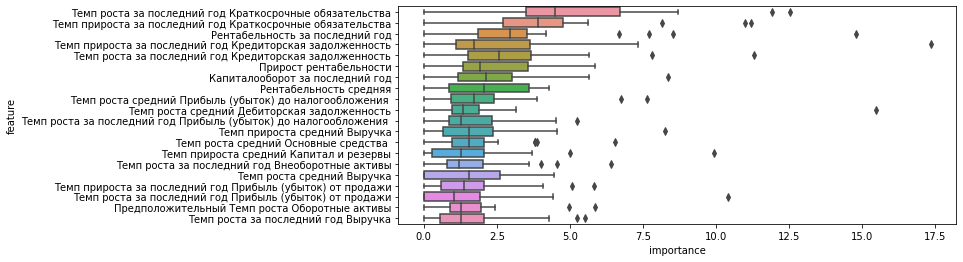

In [48]:
df_feats_imp = plot_importance(X, top, 0.20, top_n=20)

# Из графика видно, что
Можно выделить 20 показателей, на которые в наибольшей степени ориентирловались модели, а именно:

'Темп роста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Краткосрочные обязательства', 'Рентабельность за последний год', 'Темп прироста за последний год Кредиторская задолженность', 'Темп роста за последний год Кредиторская задолженность', 'Прирост рентабельности', 'Капиталооборот за последний год', 'Рентабельность средняя', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Темп роста средний Дебиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп прироста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста средний Капитал и резервы', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Выручка', 'Темп прироста за последний год Прибыль (убыток) от продажи', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Выручка'

# Проверяем лучшие модели на всех доступных данных

In [49]:
group = 'default'
models = []
for i in range(1, 17):
    models.append(load(f'models/{group}/best/model_{i}.joblib'))

test_accu(models, 2019)
test_accu(models, 2020)
test_accu(models, 2021)

Тест на данных за 2019 год
2
              precision    recall  f1-score   support

          no       0.62      0.37      0.46       224
         yes       0.65      0.84      0.73       307

    accuracy                           0.64       531
   macro avg       0.63      0.60      0.60       531
weighted avg       0.64      0.64      0.62       531

3
              precision    recall  f1-score   support

          no       0.62      0.42      0.50       224
         yes       0.66      0.81      0.73       307

    accuracy                           0.65       531
   macro avg       0.64      0.62      0.61       531
weighted avg       0.64      0.65      0.63       531

4
              precision    recall  f1-score   support

          no       0.64      0.43      0.51       224
         yes       0.66      0.83      0.74       307

    accuracy                           0.66       531
   macro avg       0.65      0.63      0.63       531
weighted avg       0.66      0.66      0.

Тест на данных за 2021 год
2
              precision    recall  f1-score   support

          no       0.63      0.24      0.35       214
         yes       0.33      0.72      0.45       111

    accuracy                           0.41       325
   macro avg       0.48      0.48      0.40       325
weighted avg       0.53      0.41      0.39       325

3
              precision    recall  f1-score   support

          no       0.66      0.30      0.41       214
         yes       0.34      0.70      0.46       111

    accuracy                           0.44       325
   macro avg       0.50      0.50      0.44       325
weighted avg       0.55      0.44      0.43       325

4
              precision    recall  f1-score   support

          no       0.65      0.24      0.35       214
         yes       0.34      0.75      0.46       111

    accuracy                           0.41       325
   macro avg       0.49      0.49      0.41       325
weighted avg       0.54      0.41      0.

# Обучаем на 20 самых важных признаках

In [50]:
first_data_pack = pd.read_csv("data/agents2021.csv")

features = ['Темп роста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Краткосрочные обязательства', 'Рентабельность за последний год', 'Темп прироста за последний год Кредиторская задолженность', 'Темп роста за последний год Кредиторская задолженность', 'Прирост рентабельности', 'Капиталооборот за последний год', 'Рентабельность средняя', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Темп роста средний Дебиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп прироста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста средний Капитал и резервы', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Выручка', 'Темп прироста за последний год Прибыль (убыток) от продажи', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Выручка']


y = get_answers(first_data_pack, 2019)
y = pd.concat([y, get_answers(first_data_pack, 2021)], ignore_index=True)

X = get_predict_data(first_data_pack, 2019, features)
X = pd.concat([X, get_predict_data(first_data_pack, 2021, features)], ignore_index=True)

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)


In [51]:
X

,Темп роста за последний год Краткосрочные обязательства,Темп прироста за последний год Краткосрочные обязательства,Рентабельность за последний год,Темп прироста за последний год Кредиторская задолженность,Темп роста за последний год Кредиторская задолженность,Прирост рентабельности,Капиталооборот за последний год,Рентабельность средняя,Темп роста средний Прибыль (убыток) до налогообложения,Темп роста средний Дебиторская задолженность,Темп роста за последний год Прибыль (убыток) до налогообложения,Темп прироста средний Выручка,Темп роста средний Основные средства,Темп прироста средний Капитал и резервы,Темп роста за последний год Внеоборотные активы,Темп роста средний Выручка,Темп прироста за последний год Прибыль (убыток) от продажи,Темп роста за последний год Прибыль (убыток) от продажи,Предположительный Темп роста Оборотные активы,Темп роста за последний год Выручка
0,1.309762,0.309762,0.020146,0.229958,1.229958,-0.128020,6.094585,0.095834,1.030343,0.985674,0.120983,0.225102,1.071915,-0.058991,1.297333,1.225102,-0.859419,0.140581,1.117329,0.889797
1,1.304966,0.304966,0.032992,0.397410,1.397410,-0.102009,1.630231,0.116127,0.479840,0.903576,0.234700,-0.035458,0.978610,0.062649,0.982893,0.964542,-1.577104,-0.577104,1.180421,0.960370
2,1.638603,0.638603,0.533402,-0.100818,0.899182,-0.037299,4.145944,0.874294,0.869650,1.765440,1.208887,0.352491,1.069972,0.123556,0.958441,1.352491,0.423698,1.423698,2.886802,1.293421
3,1.061551,0.061551,0.752357,-0.188247,0.811753,0.195108,1.051329,0.575957,1.868930,1.325500,1.862857,0.393561,1.005930,0.133370,1.018478,1.393561,0.550099,1.550099,1.916517,1.379764
4,0.464664,-0.535336,0.163221,0.341737,1.341737,-0.023449,2.848197,0.267584,0.791671,1.479357,1.096965,0.217255,1.052219,-0.516186,1.035883,1.217255,0.556365,1.556365,1.219365,1.254559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,1.270419,0.270419,0.022602,1.414430,2.414430,0.011541,3.658392,0.016713,1.912496,1.736666,3.150921,0.273043,1.778202,0.112493,1.365009,1.273043,-2.117944,-1.117944,1.595527,1.541976
640,2.513721,1.513721,0.001892,2.025372,3.025372,-0.001215,3.034355,0.005553,5.282723,5.418518,6.754125,11.696716,1.049200,0.527300,1.004485,12.696716,2.251034,3.251034,10.090414,11.092067
641,1.065144,0.065144,0.407120,0.042291,1.042291,0.113297,1.933247,0.261948,3.493832,1.522944,1.636494,0.363651,3.640280,2.366933,21.504990,1.363651,0.024616,1.024616,1.644592,1.181077
643,1.343751,0.343751,0.029431,0.360887,1.360887,-0.003237,0.988921,0.023969,2.104465,0.786011,0.946869,0.015217,0.458757,1.938227,0.623131,1.015217,-0.283289,0.716711,1.934209,1.051015


In [52]:
clfs = train(X, y)

Learning rate set to 0.009344
0:	learn: 0.5620979	test: 0.4452014	best: 0.4452014 (0)	total: 13.1ms	remaining: 2m 10s
500:	learn: 0.9923664	test: 0.5935056	best: 0.5969345 (254)	total: 1.21s	remaining: 22.9s
1000:	learn: 1.0000000	test: 0.5844758	best: 0.6144687 (885)	total: 2.42s	remaining: 21.7s
1500:	learn: 1.0000000	test: 0.5844758	best: 0.6144687 (885)	total: 3.56s	remaining: 20.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6144687367
bestIteration = 885

Shrink model to first 886 iterations.
	1, random state = 73
		model F1 = 0.6144687367130874
Learning rate set to 0.009344
0:	learn: 0.4931051	test: 0.2367053	best: 0.2367053 (0)	total: 2.69ms	remaining: 26.9s
500:	learn: 0.9924688	test: 0.5202476	best: 0.5613937 (320)	total: 1.13s	remaining: 21.4s
1000:	learn: 1.0000000	test: 0.5308466	best: 0.5613937 (320)	total: 2.24s	remaining: 20.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5613937495
bestIteration = 320

Shrink model to 

500:	learn: 0.9875605	test: 0.5027964	best: 0.5871431 (26)	total: 1.36s	remaining: 25.9s
1000:	learn: 1.0000000	test: 0.5147367	best: 0.5871431 (26)	total: 2.78s	remaining: 25s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5871430931
bestIteration = 26

Shrink model to first 27 iterations.
	16, random state = 322
		model F1 = 0.5871430930627227
Learning rate set to 0.009344
0:	learn: 0.5831278	test: 0.4837353	best: 0.4837353 (0)	total: 3.44ms	remaining: 34.4s
500:	learn: 0.9737577	test: 0.5859980	best: 0.6275959 (213)	total: 1.3s	remaining: 24.8s
1000:	learn: 1.0000000	test: 0.6197231	best: 0.6333832 (918)	total: 2.58s	remaining: 23.2s
1500:	learn: 1.0000000	test: 0.6083907	best: 0.6333832 (918)	total: 3.93s	remaining: 22.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6333831807
bestIteration = 918

Shrink model to first 919 iterations.
	17, random state = 322
		model F1 = 0.633383180705071
Learning rate set to 0.009344
0:	learn: 0.6641

500:	learn: 0.9823828	test: 0.6089099	best: 0.6313495 (193)	total: 1.29s	remaining: 24.4s
1000:	learn: 1.0000000	test: 0.6028959	best: 0.6313495 (193)	total: 2.58s	remaining: 23.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.631349523
bestIteration = 193

Shrink model to first 194 iterations.
	29, random state = 2021
		model F1 = 0.6313495230467651
Learning rate set to 0.00935
0:	learn: 0.6121932	test: 0.4663393	best: 0.4663393 (0)	total: 4.82ms	remaining: 48.2s
500:	learn: 0.9819509	test: 0.4782030	best: 0.5525142 (204)	total: 1.34s	remaining: 25.4s
1000:	learn: 1.0000000	test: 0.4907827	best: 0.5525142 (204)	total: 2.69s	remaining: 24.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5525142169
bestIteration = 204

Shrink model to first 205 iterations.
	30, random state = 2021
		model F1 = 0.5525142168718215
Learning rate set to 0.009344
0:	learn: 0.6438581	test: 0.4711030	best: 0.4711030 (0)	total: 27.5ms	remaining: 4m 34s
500:	learn:

500:	learn: 0.9824546	test: 0.5404901	best: 0.5732858 (146)	total: 1.3s	remaining: 24.6s
1000:	learn: 1.0000000	test: 0.5413758	best: 0.5912394 (922)	total: 2.62s	remaining: 23.5s
1500:	learn: 1.0000000	test: 0.6002871	best: 0.6064800 (1468)	total: 3.93s	remaining: 22.2s
2000:	learn: 1.0000000	test: 0.6064800	best: 0.6214101 (1954)	total: 5.23s	remaining: 20.9s
2500:	learn: 1.0000000	test: 0.5791427	best: 0.6214101 (1954)	total: 6.57s	remaining: 19.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6214100794
bestIteration = 1954

Shrink model to first 1955 iterations.
	45, random state = 1515
		model F1 = 0.6214100793575339
		models mean F1 = 0.6070178166724418


In [53]:
i = 1
scores = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    dump(clf, f'models/20params/model_{i}.joblib')
    print(f'{i} model F1 = {score}')
    i += 1
print('mean F1', np.mean(scores))
print('max F1', np.max(scores))

1 model F1 = 0.6144687367130874
2 model F1 = 0.5613937494914911
3 model F1 = 0.552097522802382
4 model F1 = 0.6582211250715971
5 model F1 = 0.6638121506813274
6 model F1 = 0.5730015691948813
7 model F1 = 0.6687311972445286
8 model F1 = 0.5516003898982823
9 model F1 = 0.6024706182866281
10 model F1 = 0.5674578469422458
11 model F1 = 0.6481066459138449
12 model F1 = 0.6774425055100881
13 model F1 = 0.5678360001193208
14 model F1 = 0.6451460775266296
15 model F1 = 0.5753854270764232
16 model F1 = 0.5871430930627227
17 model F1 = 0.633383180705071
18 model F1 = 0.6153525043038686
19 model F1 = 0.5980185275987911
20 model F1 = 0.6132437790106393
21 model F1 = 0.6254518755388129
22 model F1 = 0.5728211942343803
23 model F1 = 0.583158268740592
24 model F1 = 0.6838382899812072
25 model F1 = 0.6196085330332564
26 model F1 = 0.6432170371670801
27 model F1 = 0.6300590842240348
28 model F1 = 0.5689870441331799
29 model F1 = 0.6313495230467651
30 model F1 = 0.5525142168718215
31 model F1 = 0.639025

In [54]:
group = '20params'
limit = 0.55
bests = dump_best(clfs, group, limit)
top = []
for model in bests:
    score = model.best_score_['validation']['F1']
    if score < 1.:
        top.append(model)
        i += 1




1 model acuracy = 0.6144687367130874
2 model acuracy = 0.5613937494914911
3 model acuracy = 0.552097522802382
4 model acuracy = 0.6582211250715971
5 model acuracy = 0.6638121506813274
6 model acuracy = 0.5730015691948813
7 model acuracy = 0.6687311972445286
8 model acuracy = 0.5516003898982823
9 model acuracy = 0.6024706182866281
10 model acuracy = 0.5674578469422458
11 model acuracy = 0.6481066459138449
12 model acuracy = 0.6774425055100881
13 model acuracy = 0.5678360001193208
14 model acuracy = 0.6451460775266296
15 model acuracy = 0.5753854270764232
16 model acuracy = 0.5871430930627227
17 model acuracy = 0.633383180705071
18 model acuracy = 0.6153525043038686
19 model acuracy = 0.5980185275987911
20 model acuracy = 0.6132437790106393
21 model acuracy = 0.6254518755388129
22 model acuracy = 0.5728211942343803
23 model acuracy = 0.583158268740592
24 model acuracy = 0.6838382899812072
25 model acuracy = 0.6196085330332564
26 model acuracy = 0.6432170371670801
27 model acuracy = 0.630

Всего признаков 20 Усреднее по 44-ти моделям: 
['Прирост рентабельности', 'Темп прироста средний Капитал и резервы', 'Рентабельность средняя', 'Рентабельность за последний год', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Капиталооборот за последний год', 'Темп роста за последний год Выручка', 'Темп прироста средний Выручка', 'Темп роста средний Дебиторская задолженность', 'Темп роста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Кредиторская задолженность', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Краткосрочные обязательства', 'Темп роста за последний год Кредиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Темп прироста за последний год Прибыль (убыток) от продажи']
На графи

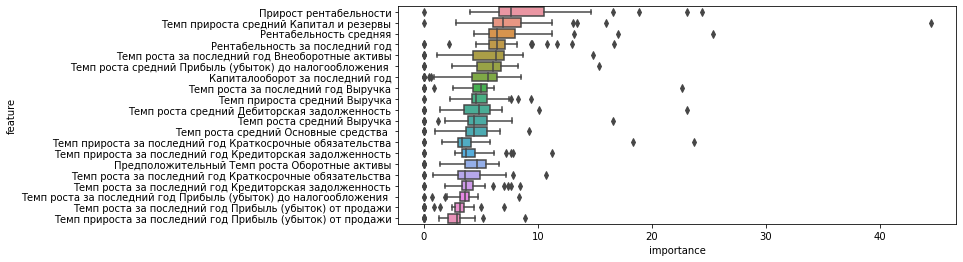

In [55]:
df_feats_imp = plot_importance(X, top, 0.20, top_n=20)

# ПРоверяем на данных за 2019, 2020, 2021

In [56]:
group = '20params'
models = []
for i in range(1, 15):
    models.append(load(f'models/{group}/best/model_{i}.joblib'))

test_accu_features(models, 2019, features)
test_accu_features(models, 2020, features)
test_accu_features(models, 2021, features)


2
              precision    recall  f1-score   support

          no       0.64      0.55      0.59       224
         yes       0.70      0.77      0.74       307

    accuracy                           0.68       531
   macro avg       0.67      0.66      0.66       531
weighted avg       0.68      0.68      0.68       531

3
              precision    recall  f1-score   support

          no       0.62      0.56      0.59       224
         yes       0.70      0.75      0.72       307

    accuracy                           0.67       531
   macro avg       0.66      0.65      0.65       531
weighted avg       0.66      0.67      0.66       531

4
              precision    recall  f1-score   support

          no       0.61      0.61      0.61       224
         yes       0.72      0.72      0.72       307

    accuracy                           0.67       531
   macro avg       0.66      0.66      0.66       531
weighted avg       0.67      0.67      0.67       531

5
           

13
              precision    recall  f1-score   support

          no       0.29      0.48      0.36       168
         yes       0.66      0.47      0.55       363

    accuracy                           0.47       531
   macro avg       0.48      0.47      0.46       531
weighted avg       0.54      0.47      0.49       531

14
              precision    recall  f1-score   support

          no       0.27      0.38      0.32       168
         yes       0.65      0.53      0.58       363

    accuracy                           0.48       531
   macro avg       0.46      0.45      0.45       531
weighted avg       0.53      0.48      0.50       531

15
              precision    recall  f1-score   support

          no       0.29      0.49      0.37       168
         yes       0.66      0.45      0.53       363

    accuracy                           0.46       531
   macro avg       0.47      0.47      0.45       531
weighted avg       0.54      0.46      0.48       531

15 mean ac

# Попробуем добавить признаки группы "Факт"

In [60]:
data_pack = pd.read_csv("data/agents2021.csv")
header = list(data_pack.columns.values)
fact_cols = []
for head in header:
    if head.startswith("Факт"):
        fact_cols.append(head)

y = get_answers(data_pack, 2021)
features = ['Прирост рентабельности', 'Темп прироста средний Капитал и резервы', 'Рентабельность средняя', 'Рентабельность за последний год', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Капиталооборот за последний год', 'Темп роста за последний год Выручка', 'Темп прироста средний Выручка', 'Темп роста средний Дебиторская задолженность', 'Темп роста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Кредиторская задолженность', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Краткосрочные обязательства', 'Темп роста за последний год Кредиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Темп прироста за последний год Прибыль (убыток) от продажи']
X = get_predict_data(data_pack, 2021, features, fact_cols)

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)
X

,Прирост рентабельности,Темп прироста средний Капитал и резервы,Рентабельность средняя,Рентабельность за последний год,Темп роста за последний год Внеоборотные активы,Темп роста средний Прибыль (убыток) до налогообложения,Капиталооборот за последний год,Темп роста за последний год Выручка,Темп прироста средний Выручка,Темп роста средний Дебиторская задолженность,...,Факт 37,Факт 39,Факт 1,Факт 2,Факт 3,Факт 7,Факт 12,Факт 14,Факт 15,Факт 16
0,0.088476,0.769794,0.110479,0.199884,1.171838,3.189879,4.529561,0.863987,-0.131344,1.205179,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
1,0.190352,-0.134296,-0.081833,-0.044069,1.055135,-3.686219,3.426823,0.937861,0.000134,1.277790,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
2,0.945770,2.231432,0.844494,1.472925,1.038433,1.969667,4.003788,1.023400,0.058023,1.352150,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
3,0.053923,-0.031859,0.686893,0.681122,1.073809,1.118037,2.458053,1.189455,0.161130,2.173383,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
4,-0.083560,4.806887,0.076573,-0.008532,0.599621,0.144407,2.048348,1.007171,-0.057684,1.074429,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0.011541,0.112493,0.016713,0.022602,1.365009,1.912496,3.658392,1.541976,0.273043,1.736666,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
315,-0.001215,0.527300,0.005553,0.001892,1.004485,5.282723,3.034355,11.092067,11.696716,5.418518,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
316,0.113297,2.366933,0.261948,0.407120,21.504990,3.493832,1.933247,1.181077,0.363651,1.522944,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
318,-0.003237,1.938227,0.023969,0.029431,0.623131,2.104465,0.988921,1.051015,0.015217,0.786011,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes


In [61]:
clfs = train_with_categories(X, y, fact_cols)

Learning rate set to 0.008043
0:	learn: 0.7144201	test: 0.4075633	best: 0.4075633 (0)	total: 4.72ms	remaining: 47.2s
500:	learn: 1.0000000	test: 0.6486071	best: 0.6486071 (171)	total: 1.56s	remaining: 29.6s
1000:	learn: 1.0000000	test: 0.6140321	best: 0.6486071 (171)	total: 3.16s	remaining: 28.4s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6486070609
bestIteration = 171

Shrink model to first 172 iterations.
	2, random state = 73
		model F1 = 0.6486070609105139
Learning rate set to 0.008052
0:	learn: 0.7260274	test: 0.4137931	best: 0.4137931 (0)	total: 14.6ms	remaining: 2m 25s
500:	learn: 1.0000000	test: 0.6201550	best: 0.6349206 (73)	total: 1.7s	remaining: 32.2s
1000:	learn: 1.0000000	test: 0.6470588	best: 0.6616541 (658)	total: 3.35s	remaining: 30.1s
1500:	learn: 1.0000000	test: 0.6330935	best: 0.6616541 (658)	total: 5s	remaining: 28.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6616541385
bestIteration = 658

Shrink model to first

500:	learn: 1.0000000	test: 0.5625000	best: 0.5760000 (386)	total: 1.75s	remaining: 33.1s
1000:	learn: 1.0000000	test: 0.5496183	best: 0.5760000 (386)	total: 3.46s	remaining: 31.1s
1500:	learn: 1.0000000	test: 0.5925926	best: 0.5925926 (1286)	total: 5.19s	remaining: 29.4s
2000:	learn: 1.0000000	test: 0.5925926	best: 0.5925926 (1286)	total: 6.97s	remaining: 27.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5925925961
bestIteration = 1286

Shrink model to first 1287 iterations.
	18, random state = 322
		model F1 = 0.5925925961247196
Learning rate set to 0.008052
0:	learn: 0.7463478	test: 0.5824670	best: 0.5824670 (0)	total: 4.08ms	remaining: 40.8s
500:	learn: 1.0000000	test: 0.5596337	best: 0.6578437 (87)	total: 1.83s	remaining: 34.8s
1000:	learn: 1.0000000	test: 0.6439547	best: 0.6578437 (87)	total: 3.66s	remaining: 32.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6578436812
bestIteration = 87

Shrink model to first 88 iterations.
	19

500:	learn: 1.0000000	test: 0.6457628	best: 0.7044882 (52)	total: 1.81s	remaining: 34.3s
1000:	learn: 1.0000000	test: 0.6881209	best: 0.7044882 (52)	total: 3.7s	remaining: 33.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.7044882027
bestIteration = 52

Shrink model to first 53 iterations.
	35, random state = 2022
		model F1 = 0.7044882027305477
Learning rate set to 0.008052
0:	learn: 0.7728158	test: 0.4790335	best: 0.4790335 (0)	total: 13.1ms	remaining: 2m 10s
500:	learn: 1.0000000	test: 0.5062859	best: 0.5712876 (10)	total: 1.91s	remaining: 36.1s
1000:	learn: 1.0000000	test: 0.5062859	best: 0.5712876 (10)	total: 3.79s	remaining: 34.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5712875822
bestIteration = 10

Shrink model to first 11 iterations.
	36, random state = 2022
		model F1 = 0.5712875822237742
Learning rate set to 0.008043
0:	learn: 0.6916913	test: 0.5620663	best: 0.5620663 (0)	total: 5.81ms	remaining: 58.1s
500:	learn: 1.0000

In [62]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    best.append(clf)
    print(f'{i} model acuracy = {score}')
    dump(clf, f'models/facts/model_{i}.joblib')
    i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.6486070609105139
2 model acuracy = 0.6616541384518452
3 model acuracy = 0.5631712200468142
4 model acuracy = 0.6795876107388424
5 model acuracy = 0.4208747063521268
6 model acuracy = 0.6176524883602337
7 model acuracy = 0.7239571987087585
8 model acuracy = 0.6788738588237196
9 model acuracy = 0.5206683778397222
10 model acuracy = 0.7767875706352994
11 model acuracy = 0.5770568884843381
12 model acuracy = 0.594044795841704
13 model acuracy = 0.6933844212429732
14 model acuracy = 0.5278744179740713
15 model acuracy = 0.6640369057764579
16 model acuracy = 0.456931495383368
17 model acuracy = 0.5925925961247196
18 model acuracy = 0.6578436811656113
19 model acuracy = 0.7308323939316804
20 model acuracy = 0.6769230797163832
21 model acuracy = 0.5815362708274056
22 model acuracy = 0.6120332915578616
23 model acuracy = 0.6120332915578616
24 model acuracy = 0.6419715597916925
25 model acuracy = 0.707482997069967
26 model acuracy = 0.5095309812404768
27 model acuracy = 0.525

In [63]:

group = 'facts'
limit = 0.65
bests = dump_best(clfs, group, limit)
top = []
for model in bests:
    score = model.best_score_['validation']['F1']
    if score < 1.:
        top.append(model)
        i += 1

1 model acuracy = 0.6616541384518452
2 model acuracy = 0.6795876107388424
3 model acuracy = 0.7239571987087585
4 model acuracy = 0.6788738588237196
5 model acuracy = 0.7767875706352994
6 model acuracy = 0.6933844212429732
7 model acuracy = 0.6640369057764579
8 model acuracy = 0.6578436811656113
9 model acuracy = 0.7308323939316804
10 model acuracy = 0.6769230797163832
11 model acuracy = 0.707482997069967
12 model acuracy = 0.7189491473099128
13 model acuracy = 0.7664289903171274
14 model acuracy = 0.6918296258941983
15 model acuracy = 0.7044882027305477
16 model acuracy = 0.7177001006987276
17 model acuracy = 0.745762712994515
18 model acuracy = 0.7205953482958609
mean AUC 0.7065065546945793
best AUC 0.7767875706352994


Всего признаков 56 Усреднее по 18-ти моделям: 
['Прирост рентабельности', 'Капиталооборот за последний год', 'Темп прироста средний Капитал и резервы', 'Темп прироста за последний год Прибыль (убыток) от продажи', 'Рентабельность средняя', 'Рентабельность за последний год', 'Темп роста средний Дебиторская задолженность', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Темп роста средний Выручка', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Внеоборотные активы', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Темп прироста средний Выручка', 'Темп роста за последний год Выручка', 'Темп роста средний Основные средства ', 'Темп прироста за последний год Кредиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп роста за последний год Краткосрочные обязательства', 'Темп роста за последний год Кредиторская задолженность', 'Темп прироста за последний год Краткосрочные обязательства', 'Факт 49

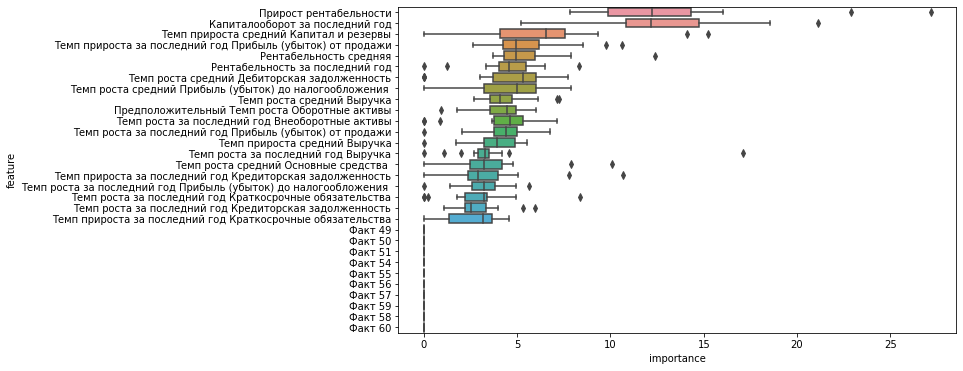

In [64]:
df_feats_imp = plot_importance(X, bests, 0.20, top_n=30)

# Из графика видно, что 
вошли такие факты как: 60, 59, 54, 29, 49

Пробуем использовать эти оцененные факты

In [66]:
data_pack = pd.read_csv('data/agents2021.csv')
fact_cols = [
    'Факт 60',
    'Факт 59',
    'Факт 54',
    'Факт 29',
    'Факт 49'
]

y = get_answers(data_pack, 2021)
features = ['Прирост рентабельности', 'Темп прироста средний Капитал и резервы', 'Рентабельность средняя', 'Рентабельность за последний год', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Капиталооборот за последний год', 'Темп роста за последний год Выручка', 'Темп прироста средний Выручка', 'Темп роста средний Дебиторская задолженность', 'Темп роста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Кредиторская задолженность', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Краткосрочные обязательства', 'Темп роста за последний год Кредиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Темп прироста за последний год Прибыль (убыток) от продажи']
X = get_predict_data(data_pack, 2021, features, fact_cols)

X['Факт наличия ПДЗ'] = y['Факт наличия ПДЗ']
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
y = X['Факт наличия ПДЗ']
X = X.drop(['Факт наличия ПДЗ'], axis = 1)
X



,Прирост рентабельности,Темп прироста средний Капитал и резервы,Рентабельность средняя,Рентабельность за последний год,Темп роста за последний год Внеоборотные активы,Темп роста средний Прибыль (убыток) до налогообложения,Капиталооборот за последний год,Темп роста за последний год Выручка,Темп прироста средний Выручка,Темп роста средний Дебиторская задолженность,...,Темп роста за последний год Краткосрочные обязательства,Темп роста за последний год Кредиторская задолженность,Темп роста за последний год Прибыль (убыток) до налогообложения,Темп роста за последний год Прибыль (убыток) от продажи,Темп прироста за последний год Прибыль (убыток) от продажи,Факт 60,Факт 59,Факт 54,Факт 29,Факт 49
0,0.088476,0.769794,0.110479,0.199884,1.171838,3.189879,4.529561,0.863987,-0.131344,1.205179,...,0.964588,0.958189,1.550132,1.632288,0.632288,yes,yes,yes,yes,yes
1,0.190352,-0.134296,-0.081833,-0.044069,1.055135,-3.686219,3.426823,0.937861,0.000134,1.277790,...,1.314372,1.501939,0.176309,2.944574,1.944574,yes,yes,yes,yes,yes
2,0.945770,2.231432,0.844494,1.472925,1.038433,1.969667,4.003788,1.023400,0.058023,1.352150,...,0.672628,1.250680,2.859484,1.020412,0.020412,yes,yes,yes,yes,yes
3,0.053923,-0.031859,0.686893,0.681122,1.073809,1.118037,2.458053,1.189455,0.161130,2.173383,...,0.426093,0.333677,1.291717,1.230115,0.230115,yes,yes,yes,yes,yes
4,-0.083560,4.806887,0.076573,-0.008532,0.599621,0.144407,2.048348,1.007171,-0.057684,1.074429,...,1.082186,1.244587,-0.114531,1.512350,0.512350,yes,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0.011541,0.112493,0.016713,0.022602,1.365009,1.912496,3.658392,1.541976,0.273043,1.736666,...,1.270419,2.414430,3.150921,-1.117944,-2.117944,yes,yes,yes,yes,yes
315,-0.001215,0.527300,0.005553,0.001892,1.004485,5.282723,3.034355,11.092067,11.696716,5.418518,...,2.513721,3.025372,6.754125,3.251034,2.251034,yes,yes,yes,yes,yes
316,0.113297,2.366933,0.261948,0.407120,21.504990,3.493832,1.933247,1.181077,0.363651,1.522944,...,1.065144,1.042291,1.636494,1.024616,0.024616,yes,yes,yes,yes,yes
318,-0.003237,1.938227,0.023969,0.029431,0.623131,2.104465,0.988921,1.051015,0.015217,0.786011,...,1.343751,1.360887,0.946869,0.716711,-0.283289,yes,yes,yes,yes,yes


In [67]:
clfs = train_with_categories(X, y, fact_cols)

Learning rate set to 0.008043
0:	learn: 0.7144201	test: 0.4075633	best: 0.4075633 (0)	total: 3.79ms	remaining: 37.9s
500:	learn: 1.0000000	test: 0.6486071	best: 0.6486071 (171)	total: 1.55s	remaining: 29.4s
1000:	learn: 1.0000000	test: 0.6140321	best: 0.6486071 (171)	total: 3.08s	remaining: 27.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6486070609
bestIteration = 171

Shrink model to first 172 iterations.
	2, random state = 73
		model F1 = 0.6486070609105139
Learning rate set to 0.008052
0:	learn: 0.7260274	test: 0.4137931	best: 0.4137931 (0)	total: 3.83ms	remaining: 38.3s
500:	learn: 1.0000000	test: 0.6201550	best: 0.6349206 (73)	total: 1.55s	remaining: 29.3s
1000:	learn: 1.0000000	test: 0.6470588	best: 0.6616541 (658)	total: 3.13s	remaining: 28.1s
1500:	learn: 1.0000000	test: 0.6330935	best: 0.6616541 (658)	total: 4.76s	remaining: 27s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6616541385
bestIteration = 658

Shrink model to firs

500:	learn: 1.0000000	test: 0.5625000	best: 0.5760000 (386)	total: 1.7s	remaining: 32.2s
1000:	learn: 1.0000000	test: 0.5496183	best: 0.5760000 (386)	total: 3.38s	remaining: 30.4s
1500:	learn: 1.0000000	test: 0.5925926	best: 0.5925926 (1286)	total: 5.23s	remaining: 29.6s
2000:	learn: 1.0000000	test: 0.5925926	best: 0.5925926 (1286)	total: 6.99s	remaining: 28s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5925925961
bestIteration = 1286

Shrink model to first 1287 iterations.
	18, random state = 322
		model F1 = 0.5925925961247196
Learning rate set to 0.008052
0:	learn: 0.7463478	test: 0.5824670	best: 0.5824670 (0)	total: 3.78ms	remaining: 37.8s
500:	learn: 1.0000000	test: 0.5596337	best: 0.6578437 (87)	total: 1.71s	remaining: 32.3s
1000:	learn: 1.0000000	test: 0.6439547	best: 0.6578437 (87)	total: 3.42s	remaining: 30.8s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6578436812
bestIteration = 87

Shrink model to first 88 iterations.
	19, r

500:	learn: 1.0000000	test: 0.6457628	best: 0.7044882 (52)	total: 1.73s	remaining: 32.9s
1000:	learn: 1.0000000	test: 0.6881209	best: 0.7044882 (52)	total: 3.57s	remaining: 32.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.7044882027
bestIteration = 52

Shrink model to first 53 iterations.
	35, random state = 2022
		model F1 = 0.7044882027305477
Learning rate set to 0.008052
0:	learn: 0.7728158	test: 0.4790335	best: 0.4790335 (0)	total: 3.42ms	remaining: 34.2s
500:	learn: 1.0000000	test: 0.5062859	best: 0.5712876 (10)	total: 1.73s	remaining: 32.8s
1000:	learn: 1.0000000	test: 0.5062859	best: 0.5712876 (10)	total: 3.48s	remaining: 31.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5712875822
bestIteration = 10

Shrink model to first 11 iterations.
	36, random state = 2022
		model F1 = 0.5712875822237742
Learning rate set to 0.008043
0:	learn: 0.6916913	test: 0.5620663	best: 0.5620663 (0)	total: 3.73ms	remaining: 37.3s
500:	learn: 1.0000

# Смотрим что получилось

In [68]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    scores.append(score)
    best.append(clf)
    print(f'{i} model acuracy = {score}')
    dump(clf, f'models/top_facts/model_{i}.joblib')
    i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.6486070609105139
2 model acuracy = 0.6616541384518452
3 model acuracy = 0.5631712200468142
4 model acuracy = 0.6795876107388424
5 model acuracy = 0.4208747063521268
6 model acuracy = 0.6176524883602337
7 model acuracy = 0.7239571987087585
8 model acuracy = 0.6788738588237196
9 model acuracy = 0.5206683778397222
10 model acuracy = 0.7767875706352994
11 model acuracy = 0.5770568884843381
12 model acuracy = 0.594044795841704
13 model acuracy = 0.6933844212429732
14 model acuracy = 0.5278744179740713
15 model acuracy = 0.6640369057764579
16 model acuracy = 0.456931495383368
17 model acuracy = 0.5925925961247196
18 model acuracy = 0.6578436811656113
19 model acuracy = 0.7308323939316804
20 model acuracy = 0.6769230797163832
21 model acuracy = 0.5815362708274056
22 model acuracy = 0.6120332915578616
23 model acuracy = 0.6120332915578616
24 model acuracy = 0.6419715597916925
25 model acuracy = 0.707482997069967
26 model acuracy = 0.5095309812404768
27 model acuracy = 0.525

In [69]:
i = 1
scores = []
best = []
for clf in clfs:
    score = clf.best_score_['validation']['F1']
    if score > 0.7:
        scores.append(score)
        best.append(clf)
        print(f'{i} model acuracy = {score}')
        dump(clf, f'models/top_facts/best/model_{i}.joblib')
        i += 1
print('mean AUC', np.mean(scores))
print('best AUC', np.max(scores))

1 model acuracy = 0.7239571987087585
2 model acuracy = 0.7767875706352994
3 model acuracy = 0.7308323939316804
4 model acuracy = 0.707482997069967
5 model acuracy = 0.7189491473099128
6 model acuracy = 0.7664289903171274
7 model acuracy = 0.7044882027305477
8 model acuracy = 0.7177001006987276
9 model acuracy = 0.745762712994515
10 model acuracy = 0.7205953482958609
mean AUC 0.7312984662692397
best AUC 0.7767875706352994


In [70]:
df = pd.read_csv('data/agents2020.csv')
df

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 4,Факт. 5,Факт. 6,Факт 7,Факт. 8,Факт. 9,...,"2018, Себестоимость продаж, RUB","2019, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2019, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB","2019, Прибыль (убыток) от продажи, RUB"
0,0,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,3.438313e+10,2.673481e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.603784e+09,3.280355e+09,6.200120e+09,8.716191e+08,3.658634e+09
1,1,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,4.169796e+08,5.349955e+08,1.212357e+07,6.944586e+06,4.480064e+07,8.747516e+07,1.630064e+07,1.109172e+07,5.135732e+07,9.411019e+07
2,2,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,2.316724e+09,2.460679e+09,5.026662e+08,3.644229e+08,8.552994e+07,-6.456439e+08,4.148586e+08,1.611318e+08,-9.298981e+07,-1.207210e+08
3,3,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.171315e+10,1.272604e+10,4.100857e+09,4.481281e+09,6.840634e+09,3.999298e+09,4.903117e+09,5.186553e+09,7.869977e+09,4.029232e+09
4,4,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,2.652547e+10,3.055828e+10,7.163980e+10,3.799862e+10,4.593606e+10,4.960408e+10,2.338912e+10,3.727984e+10,5.307524e+10,5.622122e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.047255e+08,2.884618e+08,7.961783e+05,7.751592e+05,6.176433e+06,1.580637e+07,1.174522e+06,8.923567e+05,6.782166e+06,2.074204e+07
527,527,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.008364e+09,9.064178e+08,1.490363e+08,1.553159e+08,8.043376e+07,6.917389e+07,1.426694e+08,1.465019e+08,6.499554e+07,7.620446e+07
528,528,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
529,529,Х,Х,Х,Х,Х,Х,Х,Х,Х,...,1.300605e+08,5.352535e+08,1.160510e+06,5.324204e+07,1.720955e+08,4.331529e+07,3.604459e+06,7.276369e+07,2.052898e+08,1.427178e+08


In [71]:
models = []
for i in range(1,16):
    models.append(load(f'models/top_facts/best/model_{i}.joblib'))

fact_cols = [
    'Факт 60',
    'Факт 59',
    'Факт 54',
    'Факт 29',
    'Факт 49'
]

test_accu_cat(models, 2020, features, fact_cols)
test_accu_cat(models, 2021, features, fact_cols)

2
              precision    recall  f1-score   support

          no       0.30      0.63      0.41       168
         yes       0.66      0.33      0.43       363

    accuracy                           0.42       531
   macro avg       0.48      0.48      0.42       531
weighted avg       0.54      0.42      0.43       531

3
              precision    recall  f1-score   support

          no       0.29      0.67      0.41       168
         yes       0.63      0.26      0.37       363

    accuracy                           0.39       531
   macro avg       0.46      0.46      0.39       531
weighted avg       0.52      0.39      0.38       531

4
              precision    recall  f1-score   support

          no       0.30      0.70      0.42       168
         yes       0.64      0.25      0.36       363

    accuracy                           0.39       531
   macro avg       0.47      0.48      0.39       531
weighted avg       0.53      0.39      0.38       531

5
           

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name Рентабельность за последний год (found Прирост рентабельности).

# Пробуем на самых оптимальных признаках обучить модели группирующие по срокам просрочки


In [4]:
data_pack = pd.read_csv('data/agents2021.csv')

features = ['Прирост рентабельности', 'Темп прироста средний Капитал и резервы', 'Рентабельность средняя', 'Рентабельность за последний год', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Капиталооборот за последний год', 'Темп роста за последний год Выручка', 'Темп прироста средний Выручка', 'Темп роста средний Дебиторская задолженность', 'Темп роста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Кредиторская задолженность', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Краткосрочные обязательства', 'Темп роста за последний год Кредиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Темп прироста за последний год Прибыль (убыток) от продажи']
X = get_predict_data(data_pack, 2021, features)

y1 = get_answers_group(data_pack, 2021, 1)
y2 = get_answers_group(data_pack, 2021, 2)
y3 = get_answers_group(data_pack, 2021, 3)
y4 = get_answers_group(data_pack, 2021, 4)

X['Группа ПДЗ 1-30'] = y1['Группа ПДЗ 1-30']
X['Группа ПДЗ 31-90'] = y2['Группа ПДЗ 31-90']
X['Группа ПДЗ 91-365'] = y3['Группа ПДЗ 91-365']
X['Группа ПДЗ 365+'] = y4['Группа ПДЗ 365+']

X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]

y1 = X['Группа ПДЗ 1-30']
y2 = X['Группа ПДЗ 31-90']
y3 = X['Группа ПДЗ 91-365']
y4 = X['Группа ПДЗ 365+']
X = X.drop(['Группа ПДЗ 1-30', 'Группа ПДЗ 31-90', 'Группа ПДЗ 91-365', 'Группа ПДЗ 365+'], axis = 1)
X


,Прирост рентабельности,Темп прироста средний Капитал и резервы,Рентабельность средняя,Рентабельность за последний год,Темп роста за последний год Внеоборотные активы,Темп роста средний Прибыль (убыток) до налогообложения,Капиталооборот за последний год,Темп роста за последний год Выручка,Темп прироста средний Выручка,Темп роста средний Дебиторская задолженность,Темп роста средний Выручка,Темп роста средний Основные средства,Темп прироста за последний год Краткосрочные обязательства,Темп прироста за последний год Кредиторская задолженность,Предположительный Темп роста Оборотные активы,Темп роста за последний год Краткосрочные обязательства,Темп роста за последний год Кредиторская задолженность,Темп роста за последний год Прибыль (убыток) до налогообложения,Темп роста за последний год Прибыль (убыток) от продажи,Темп прироста за последний год Прибыль (убыток) от продажи
0,0.088476,0.769794,0.110479,0.199884,1.171838,3.189879,4.529561,0.863987,-0.131344,1.205179,0.868656,1.435599,-0.035412,-0.041811,1.267656,0.964588,0.958189,1.550132,1.632288,0.632288
1,0.190352,-0.134296,-0.081833,-0.044069,1.055135,-3.686219,3.426823,0.937861,0.000134,1.277790,1.000134,1.070788,0.314372,0.501939,0.613035,1.314372,1.501939,0.176309,2.944574,1.944574
2,0.945770,2.231432,0.844494,1.472925,1.038433,1.969667,4.003788,1.023400,0.058023,1.352150,1.058023,1.045111,-0.327372,0.250680,1.732825,0.672628,1.250680,2.859484,1.020412,0.020412
3,0.053923,-0.031859,0.686893,0.681122,1.073809,1.118037,2.458053,1.189455,0.161130,2.173383,1.161130,1.082381,-0.573907,-0.666323,0.572871,0.426093,0.333677,1.291717,1.230115,0.230115
4,-0.083560,4.806887,0.076573,-0.008532,0.599621,0.144407,2.048348,1.007171,-0.057684,1.074429,0.942316,1.052151,0.082186,0.244587,2.239035,1.082186,1.244587,-0.114531,1.512350,0.512350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0.011541,0.112493,0.016713,0.022602,1.365009,1.912496,3.658392,1.541976,0.273043,1.736666,1.273043,1.778202,0.270419,1.414430,1.595527,1.270419,2.414430,3.150921,-1.117944,-2.117944
315,-0.001215,0.527300,0.005553,0.001892,1.004485,5.282723,3.034355,11.092067,11.696716,5.418518,12.696716,1.049200,1.513721,2.025372,10.090414,2.513721,3.025372,6.754125,3.251034,2.251034
316,0.113297,2.366933,0.261948,0.407120,21.504990,3.493832,1.933247,1.181077,0.363651,1.522944,1.363651,3.640280,0.065144,0.042291,1.644592,1.065144,1.042291,1.636494,1.024616,0.024616
318,-0.003237,1.938227,0.023969,0.029431,0.623131,2.104465,0.988921,1.051015,0.015217,0.786011,1.015217,0.458757,0.343751,0.360887,1.934209,1.343751,1.360887,0.946869,0.716711,-0.283289


In [5]:

clfs1 = train(X, y1)
clfs2 = train(X, y2)
clfs3 = train(X, y3)
clfs4 = train(X, y4)

Learning rate set to 0.008043
0:	learn: 0.6144509	test: 0.3425671	best: 0.3425671 (0)	total: 167ms	remaining: 27m 50s
500:	learn: 1.0000000	test: 0.0000000	best: 0.3425671 (0)	total: 1.08s	remaining: 20.5s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.3425671 (0)	total: 2s	remaining: 17.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.3425671232
bestIteration = 0

Shrink model to first 1 iterations.
	1, random state = 73
		model F1 = 0.3425671231558509
Learning rate set to 0.008052
0:	learn: 0.5805728	test: 0.0000000	best: 0.0000000 (0)	total: 2.04ms	remaining: 20.4s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 890ms	remaining: 16.9s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.77s	remaining: 15.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	2, random state = 73
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.4022145	test: 0.00

500:	learn: 1.0000000	test: 0.0000000	best: 0.5427943 (2)	total: 1.02s	remaining: 19.4s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.5427943 (2)	total: 2s	remaining: 18s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5427942759
bestIteration = 2

Shrink model to first 3 iterations.
	18, random state = 322
		model F1 = 0.5427942758819102
Learning rate set to 0.008052
0:	learn: 0.5008652	test: 0.0000000	best: 0.0000000 (0)	total: 2.24ms	remaining: 22.4s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 991ms	remaining: 18.8s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2s	remaining: 18s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	19, random state = 322
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.4148853	test: 0.4340444	best: 0.4340444 (0)	total: 15.3ms	remaining: 2m 32s
500:	learn: 1.0000000	test: 0.0000000	best: 0.5714286 (2)	total

1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.16s	remaining: 19.4s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	35, random state = 2022
		model F1 = 0.0
Learning rate set to 0.008043
0:	learn: 0.3292950	test: 0.0000000	best: 0.0000000 (0)	total: 2.45ms	remaining: 24.5s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 992ms	remaining: 18.8s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2s	remaining: 18s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	36, random state = 2402
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.4750708	test: 0.4949956	best: 0.4949956 (0)	total: 2.41ms	remaining: 24.1s
500:	learn: 1.0000000	test: 0.2500000	best: 0.5098673 (1)	total: 1.03s	remaining: 19.6s
1000:	learn: 1.0000000	test: 0.2500000	best: 0.5098673 (1)	total: 2.05s	remaining: 

500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 1.01s	remaining: 19.1s
1000:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 2.02s	remaining: 18.2s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 1
bestIteration = 2

Shrink model to first 3 iterations.
	8, random state = 42
		model F1 = 1.0
Learning rate set to 0.008052
0:	learn: 0.7544693	test: 0.0000000	best: 0.0000000 (0)	total: 11.7ms	remaining: 1m 57s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.04s	remaining: 19.8s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.04s	remaining: 18.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	9, random state = 42
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.7613568	test: 0.0000000	best: 0.0000000 (0)	total: 2.29ms	remaining: 22.9s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1s	remaining: 19.1

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.06s	remaining: 20.2s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.12s	remaining: 19.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	26, random state = 2021
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.6082708	test: 0.0000000	best: 0.0000000 (0)	total: 2.23ms	remaining: 22.3s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.02s	remaining: 19.4s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.06s	remaining: 18.5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	27, random state = 2021
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.5098562	test: 0.0000000	best: 0.0000000 (0)	total: 2.26ms	remaining: 22.6s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.11s	remaini

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.1s	remaining: 20.8s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.21s	remaining: 19.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	44, random state = 1515
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.6879448	test: 0.0000000	best: 0.0000000 (0)	total: 11.7ms	remaining: 1m 57s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.05s	remaining: 20s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.08s	remaining: 18.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	45, random state = 1515
		model F1 = 0.0
		models mean F1 = 0.1440029332576103
Learning rate set to 0.008043
0:	learn: 0.8110271	test: 0.3390965	best: 0.3390965 (0)	total: 2.21ms	remaining: 22.1s
500:	learn: 1.0000000	test: 0.0000000	best

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.12s	remaining: 21.3s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.19s	remaining: 19.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	17, random state = 322
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.1959992	test: 0.0000000	best: 0.0000000 (0)	total: 2.17ms	remaining: 21.7s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.05s	remaining: 20s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.1s	remaining: 18.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	18, random state = 322
		model F1 = 0.0
Learning rate set to 0.008052
0:	learn: 0.7163308	test: 0.0000000	best: 0.0000000 (0)	total: 15.5ms	remaining: 2m 34s
500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.04s	remaining: 

500:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 1.05s	remaining: 19.8s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 2.11s	remaining: 18.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.
	35, random state = 2022
		model F1 = 0.0
Learning rate set to 0.008043
0:	learn: 0.6232089	test: 0.5866485	best: 0.5866485 (0)	total: 2.45ms	remaining: 24.5s
500:	learn: 1.0000000	test: 0.0000000	best: 0.5866485 (0)	total: 1.03s	remaining: 19.6s
1000:	learn: 1.0000000	test: 0.0000000	best: 0.5866485 (0)	total: 2.1s	remaining: 18.9s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5866484794
bestIteration = 0

Shrink model to first 1 iterations.
	36, random state = 2402
		model F1 = 0.5866484793969103
Learning rate set to 0.008052
0:	learn: 0.7648091	test: 0.4000000	best: 0.4000000 (0)	total: 2.29ms	remaining: 22.9s
500:	learn: 1.0000000	test: 0.0000000	best: 0.4000000

500:	learn: 1.0000000	test: 0.2694723	best: 0.6368134 (1)	total: 1.1s	remaining: 20.9s
1000:	learn: 1.0000000	test: 0.2620247	best: 0.6368134 (1)	total: 2.17s	remaining: 19.5s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6368133621
bestIteration = 1

Shrink model to first 2 iterations.
	7, random state = 42
		model F1 = 0.6368133621051639
Learning rate set to 0.008052
0:	learn: 0.7595989	test: 0.8331773	best: 0.8331773 (0)	total: 11.9ms	remaining: 1m 59s
500:	learn: 1.0000000	test: 0.5454545	best: 0.8331773 (0)	total: 1.07s	remaining: 20.3s
1000:	learn: 1.0000000	test: 0.5454545	best: 0.8331773 (0)	total: 2.15s	remaining: 19.3s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8331772869
bestIteration = 0

Shrink model to first 1 iterations.
	8, random state = 42
		model F1 = 0.8331772868593651
Learning rate set to 0.008052
0:	learn: 0.7574752	test: 0.4665815	best: 0.4665815 (0)	total: 2.44ms	remaining: 24.4s
500:	learn: 1.0000000	test: 0.28

500:	learn: 1.0000000	test: 0.4285714	best: 0.7058824 (9)	total: 1.11s	remaining: 21.1s
1000:	learn: 1.0000000	test: 0.4038121	best: 0.7058824 (9)	total: 2.18s	remaining: 19.6s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.7058823529
bestIteration = 9

Shrink model to first 10 iterations.
	24, random state = 777
		model F1 = 0.7058823529411764
Learning rate set to 0.008052
0:	learn: 0.7890548	test: 0.4219957	best: 0.4219957 (0)	total: 16.6ms	remaining: 2m 46s
500:	learn: 1.0000000	test: 0.6165929	best: 0.6165929 (389)	total: 1.06s	remaining: 20.1s
1000:	learn: 1.0000000	test: 0.6165929	best: 0.6165929 (389)	total: 2.12s	remaining: 19s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6165929382
bestIteration = 389

Shrink model to first 390 iterations.
	25, random state = 777
		model F1 = 0.6165929382367047
Learning rate set to 0.008043
0:	learn: 0.5369901	test: 0.4228714	best: 0.4228714 (0)	total: 2.36ms	remaining: 23.6s
500:	learn: 1.000000

500:	learn: 1.0000000	test: 0.4615385	best: 0.5714286 (192)	total: 1.07s	remaining: 20.3s
1000:	learn: 1.0000000	test: 0.4465085	best: 0.5714286 (192)	total: 2.13s	remaining: 19.1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5714285714
bestIteration = 192

Shrink model to first 193 iterations.
	41, random state = 1515
		model F1 = 0.5714285714285715
Learning rate set to 0.008052
0:	learn: 0.7193646	test: 0.3280127	best: 0.3280127 (0)	total: 2.19ms	remaining: 21.9s
500:	learn: 1.0000000	test: 0.2978585	best: 0.4911714 (1)	total: 1.04s	remaining: 19.8s
1000:	learn: 1.0000000	test: 0.2978585	best: 0.4911714 (1)	total: 2.09s	remaining: 18.8s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.4911714182
bestIteration = 1

Shrink model to first 2 iterations.
	42, random state = 1515
		model F1 = 0.4911714181832145
Learning rate set to 0.008052
0:	learn: 0.7099723	test: 0.5631686	best: 0.5631686 (0)	total: 2.67ms	remaining: 26.8s
500:	learn: 1.0000

In [77]:

best1 = dump_best(clfs1, 'group1', 0.6)
best2 = dump_best(clfs2, 'group2', 0.6)
best3 = dump_best(clfs3, 'group3', 0.6)
best4 = dump_best(clfs4, 'group4', 0.6)

1 model acuracy = 0.6448580198776062
2 model acuracy = 0.6186885913344886
3 model acuracy = 0.7314376769883536
4 model acuracy = 0.7103888522856399
5 model acuracy = 0.6474973187691891
6 model acuracy = 0.6628675295689359
7 model acuracy = 0.6748669280203964
8 model acuracy = 0.6007202787997494
9 model acuracy = 0.6869430761602935
10 model acuracy = 0.6461709511376024
11 model acuracy = 0.6330233284483935
12 model acuracy = 0.6270173780381841
13 model acuracy = 0.63807666101482
14 model acuracy = 0.6222253116804397
15 model acuracy = 0.626838535850558
16 model acuracy = 0.6109289678689404
17 model acuracy = 0.6534928595198818
18 model acuracy = 0.6710358543694066
19 model acuracy = 0.605702970745411
20 model acuracy = 0.6061916177358796
21 model acuracy = 0.6674709681126665
mean AUC 0.646973508396516
best AUC 0.7314376769883536
1 model acuracy = 1.0
2 model acuracy = 0.6666666666666666
mean AUC 0.8333333333333333
best AUC 1.0
1 model acuracy = 0.6666666666666666
2 model acuracy = 1.0
3

In [81]:


features = ['Прирост рентабельности', 'Темп прироста средний Капитал и резервы', 'Рентабельность средняя', 'Рентабельность за последний год', 'Темп роста за последний год Внеоборотные активы', 'Темп роста средний Прибыль (убыток) до налогообложения ', 'Капиталооборот за последний год', 'Темп роста за последний год Выручка', 'Темп прироста средний Выручка', 'Темп роста средний Дебиторская задолженность', 'Темп роста средний Выручка', 'Темп роста средний Основные средства ', 'Темп прироста за последний год Краткосрочные обязательства', 'Темп прироста за последний год Кредиторская задолженность', 'Предположительный Темп роста Оборотные активы', 'Темп роста за последний год Краткосрочные обязательства', 'Темп роста за последний год Кредиторская задолженность', 'Темп роста за последний год Прибыль (убыток) до налогообложения ', 'Темп роста за последний год Прибыль (убыток) от продажи', 'Темп прироста за последний год Прибыль (убыток) от продажи']

year = 2020
test_accu_cat_group(best1, year, features, 1)



2
              precision    recall  f1-score   support

          no       0.51      0.63      0.56       251
         yes       0.58      0.46      0.51       280

    accuracy                           0.54       531
   macro avg       0.54      0.54      0.54       531
weighted avg       0.55      0.54      0.54       531

3
              precision    recall  f1-score   support

          no       0.52      0.70      0.59       251
         yes       0.61      0.42      0.49       280

    accuracy                           0.55       531
   macro avg       0.56      0.56      0.54       531
weighted avg       0.56      0.55      0.54       531

4
              precision    recall  f1-score   support

          no       0.49      0.57      0.52       251
         yes       0.54      0.46      0.50       280

    accuracy                           0.51       531
   macro avg       0.52      0.52      0.51       531
weighted avg       0.52      0.51      0.51       531

5
           

In [83]:

test_accu_cat_group(best2, year, features, 2)

2
              precision    recall  f1-score   support

          no       0.90      0.93      0.92       481
         yes       0.06      0.04      0.05        50

    accuracy                           0.85       531
   macro avg       0.48      0.48      0.48       531
weighted avg       0.82      0.85      0.83       531

3
              precision    recall  f1-score   support

          no       0.91      1.00      0.95       481
         yes       0.00      0.00      0.00        50

    accuracy                           0.91       531
   macro avg       0.45      0.50      0.48       531
weighted avg       0.82      0.91      0.86       531

3 mean acuracy = 0.8757062146892656


C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drizh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:

test_accu_cat_group(best3, year, features, 3)

2
              precision    recall  f1-score   support

          no       0.95      0.98      0.96       504
         yes       0.08      0.04      0.05        27

    accuracy                           0.93       531
   macro avg       0.52      0.51      0.51       531
weighted avg       0.91      0.93      0.92       531

3
              precision    recall  f1-score   support

          no       0.95      0.99      0.97       504
         yes       0.12      0.04      0.06        27

    accuracy                           0.94       531
   macro avg       0.54      0.51      0.51       531
weighted avg       0.91      0.94      0.92       531

4
              precision    recall  f1-score   support

          no       0.95      0.97      0.96       504
         yes       0.15      0.11      0.13        27

    accuracy                           0.92       531
   macro avg       0.55      0.54      0.54       531
weighted avg       0.91      0.92      0.92       531

5
           

In [86]:

test_accu_cat_group(best4, year, features, 4)

2
              precision    recall  f1-score   support

          no       0.99      0.96      0.97       525
         yes       0.00      0.00      0.00         6

    accuracy                           0.95       531
   macro avg       0.49      0.48      0.49       531
weighted avg       0.98      0.95      0.96       531

3
              precision    recall  f1-score   support

          no       0.99      0.98      0.99       525
         yes       0.11      0.17      0.13         6

    accuracy                           0.98       531
   macro avg       0.55      0.58      0.56       531
weighted avg       0.98      0.98      0.98       531

4
              precision    recall  f1-score   support

          no       0.99      0.98      0.98       525
         yes       0.00      0.00      0.00         6

    accuracy                           0.96       531
   macro avg       0.49      0.49      0.49       531
weighted avg       0.98      0.96      0.97       531

5
           

идея 1) попробовать добавить факты просрочки по диапазонам за прошлый год, чтобы повысить точность предсказания по категориям.
Неудача, те кто задолжали один раз в любой год вопринимаются моделью как точно просрочат.
Идея 2) Попробовать рассчитывать возможность малой просрочки через удаление из предсказанных моделью, определяющей факт просрочки, данных значений, предсказанных моделями обученными для предсказания остальных значений.
относительно малые погрешности, при взаимодействии складываются и получается довольно серьезная погрешность.
Идея 3) Попробовать сформулировать на основе значений рейтинг, показывающий потенциальную вероятность просрочки.
Не удалось подобрать 